## Notes

Classification: predicting classes/categories


### Introducing MNIST
- handwritten digits

In [1]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

- 70K samples, 784 features (28x28 pixels)

In [7]:
y.shape

(70000,)

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

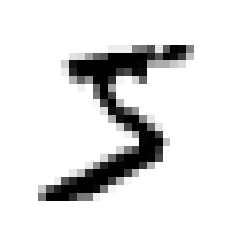

In [11]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [12]:
y[0]

'5'

- cast target variable to integers

In [14]:
import numpy as np

In [15]:
y = y.astype(np.uint8)

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:],

- dataset is already shuffled, some CV folds will be similar (no missing digits)

### Training a binary classifier
- simplify the problem to classifying a single digit
- Stochastic Gradient Descent (SGD) classifier: good for large datasets, deals with training instances independently, one at a time
- relies on randomness

In [17]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [20]:
from sklearn.linear_model import SGDClassifier

In [21]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

- Can use cross validation
- Custom implementation of CV:

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [31]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


- performs stratified sampling to get a representative ratio of each class

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- accuracy doesn't mean much here, since about 10% of the samples are 5s. If you guess non-5 for every sample you'll get around 90% accuracy

In [34]:
from sklearn.base import BaseEstimator

In [35]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [36]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

- accuracy is generally not the preferred performance measure, especially with skewed datasets

**Confusion Matrix**
- count the number of times instances of class A are classfied as class B

In [37]:
from sklearn.model_selection import cross_val_predict

- `cross_val_predict` returns the predictions for each test fold

In [38]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [41]:
y_train_pred.shape

(60000,)

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- each row represents an actual class
- each column represents a predicted class
- first row of this matrix is non-5s, second row is 5s


- row 1 col 1: true negatives
- row 1 col 2: false positives
- row 2 col 1: false negatives
- row 2 col 2: true positives
- a perfect classifier would only have true positives and true negatives

In [48]:
# pretending we reached perfection
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Precision and Recall**

Precision: accuracy of positive predictions
$$ precision = \frac{TP}{TP+FP} $$

Recall (AKA sensitivity or True Positive Rate):
$$ recall = \frac{TP}{TP+FN} $$

In [49]:
from sklearn.metrics import precision_score, recall_score

In [50]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [51]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- higher precision than recall: when the classifier predicted a 5, it was likely to be correct. however, this came at the cost of incorrectly predicting non-5 on samples that it was less sure about
- its convenient to combine precision and recall into a single metric, the F1 score:

$$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2\times\frac{precision\times{recall}}{precision + recall} = \frac{TP}{TP + \frac{FN+TP}{2}}$$
- this is the harmonic mean; while regular mean treats all values equally, harmonic mean gives much more weight to low values
- F1 is only high if both precision and recall are

In [52]:
from sklearn.metrics import f1_score

In [53]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- while F1 is a metric that favours equally good precision and recall, there are instances when prioritizing one of the two is more valuable
- e.g. a classifier that detects whether videos are safe for kids: you want high precision because the cost of being wrong is very high, and its better to reject potentially safe videos if it ensures that no unsafe videos are recommended
- e.g. a classifier for catching shoplifting can favour recall; maximizing the potential for catching all instances of shoplifting is well worth the potential for a few false positives here and there
- there is a tradeoff between precision and recall, can't have it both ways

**Precision/Recall Trade-Off**
- controlled by the threshold at which a sample is classified as true
- can control this threshold by calling `decision_function()` instead of `predict()` for sklearn estimators and setting a threshold yourself:

In [54]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [57]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [58]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- raising the threshold increases precision and lowers recall
- lowering the threshold increases recall and lowers precision

In [59]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [61]:
from sklearn.metrics import precision_recall_curve

In [122]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [124]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, figsize=(10,6)):
    plt.figure(figsize=figsize)
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.legend()

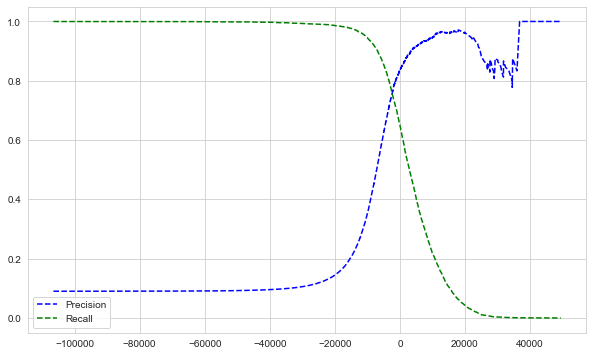

In [125]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- precision can go down when the threshold increases
- e.g. getting 4/5 (80%) correct, then raising threshold and getting 3/4 correct (75%)
- can also plot precision vs. recall directly:

In [93]:
def plot_precision_vs_recall(precisions, recalls, figsize=(10,6)):
    plt.figure(figsize=figsize)
    plt.plot(recalls, precisions, 'b--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

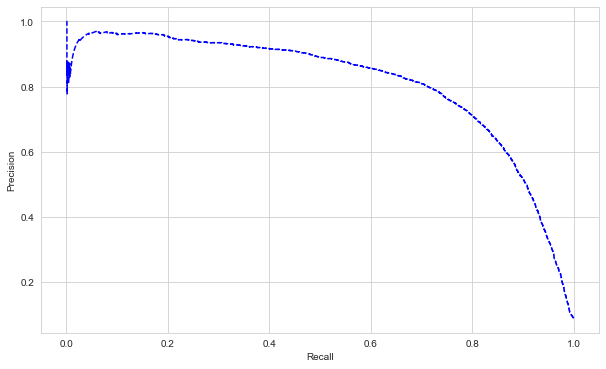

In [119]:
plot_precision_vs_recall(precisions, recalls)
plt.show()

- precision really starts to dip around 70% recall
- might make sense to set the threshold before that drop, but depends on the context of your project
- to set the threshold at a specific precision:
- `np.argmax()` gives the first index of the maximum value; in this case, the first instance where precision > 90 is true

In [110]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [111]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [112]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [113]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

**The ROC Curve**

- Receiver Operating Characteristic
- plots true positive rate (TPR) vs false positive rate (FPR)
- FPR is ratio of false positives, i.e. 1 - True Negative Rate (TNR)
- TNR is also known as specificity
- ROC is plotting sensitivity (recall) vs 1 - specificity

In [114]:
from sklearn.metrics import roc_curve

In [115]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [126]:
def plot_roc_curve(fpr, tpr, label=None, figsize=(10,6)):
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()

No handles with labels found to put in legend.


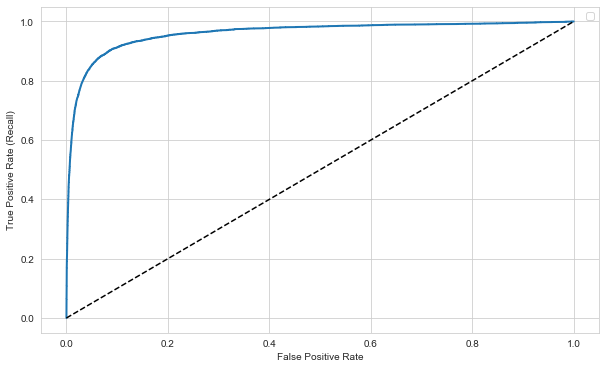

In [127]:
plot_roc_curve(fpr, tpr)
plt.show()

- dotted line represents purely random classifier
- good classifiers have the highest true positive rate with the lowest false positive rate (top left corner)
- can compare ROC scores of different classifiers by measuring area under the curve AUC
- a purely random classifier will have an AUC of 0.5 (think the integral of the purely random classifier, the linear line)
- false positive rate is so high here because there aren't that many 5s in the data (only about 10%), so don't get misled by the great looking ROC curve

In [128]:
from sklearn.metrics import roc_auc_score

In [129]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- use the precision/recall curve when the positive class is rare or you care more about the false positives than the false negatives
- otherwise use the ROC curve
- for skewed datasets where the positive class is rare, you can see that precision really suffers when recall increases (a result of having less training data on the positive class, the classifier is trying to catch every positive class despite not having a lot to go off of). paints a different picture than ROC
- Try calculating ROC, AUC, Precision and Recall for Random Forest estimator:

In [130]:
from sklearn.ensemble import RandomForestClassifier

In [131]:
forest_clf = RandomForestClassifier(random_state=42)

In [132]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

/Users/willbarker/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/willbarker/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/willbarker/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [137]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

In [138]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,
                                                      y_scores_forest)

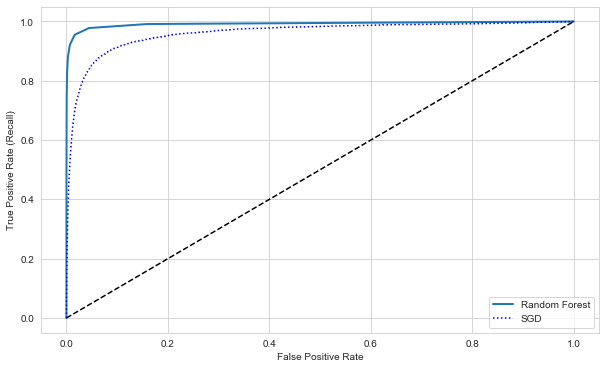

In [143]:
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.plot(fpr, tpr, "b:", label="SGD")
plt.legend()
plt.show()

- Closer to top left than SGD, more AUC, better performance
- Explaining the ROC curve: to achieve an almost 99% recall/TPR rate (we correctly predict positive for 99% of all the real positive samples in the dataset), it seems like we will have to accept the tradeoff of getting 15% of the negative samples incorrectly predicted as positive (the false positive rate)

In [144]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

In [147]:
y_preds_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                        cv=3)

/Users/willbarker/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/willbarker/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/willbarker/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [148]:
precision_score(y_train_5, y_preds_forest)

0.986046511627907

In [149]:
recall_score(y_train_5, y_preds_forest)

0.8212506917542889

### Multiclass Classification
- AKA multinomial
- Logistic Regression, Random Forest, naive Bayes classifiers are examples of algorithms that can make multiclass classifications natively
- Can get around this with algos that only work as binary; in the example of MNIST train 10 binary classifiers, pick the class with the highest decision score. Known as one-versus-rest/one-versus-all strategy (OvR).
- You could also train a binary classifier for every pair of digits. i.e. 1 vs 2, 1 vs 3, 2 vs 5, etc. This is one-versus-one (OvO) strategy, and you pick the classifier that wins the most duels. Advantage of this strategy is that you only train the classifiers on subsets of the entire target variable space
- Some algos scale poorly with the size of the training set, so OvO strategy is preferred
- In general however, OvR is preferred, as its more straightforward
- Sklearn classifiers will automatically detecty multiclass classifications from the target variable and will use a strategy based on the algorithm used

In [150]:
from sklearn.svm import SVC

In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # all digits in target variable
svm_clf.predict([some_digit])

/Users/willbarker/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


- SVC uses OvO strategy; it actually trained 45 binary classifiers
- `decision_function()` returns 10 scores per instance, and classifier picked the highest one: